In [108]:
# Dependencies
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import IPython.display as ipd
from glob import glob
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
from IPython.display import Audio
from keras.models import load_model

In [64]:
# Load audio file and extract chroma features
audio_files = glob(r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets\*\*.wav')


In [74]:
# Load and preprocess the audio data
def add_white_noise(data, noise_level=0.005):
    max_amplitude = np.max(np.abs(data))
    noise_amp = noise_level * max_amplitude
    white_noise = noise_amp * np.random.normal(size=len(data))
    noisy_data = data + white_noise
    return noisy_data

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def time_shift(data, max_shift_ms=50):
    shift_range = int(np.random.uniform(low=-max_shift_ms, high=max_shift_ms) * 1000)
    return np.roll(data, shift_range)

def random_pitch_shift(data, sr, pitch_range=(-2, 2)):
    pitch_shift_semitones = np.random.uniform(*pitch_range)
    pitch_factor = 2 ** (pitch_shift_semitones / 12.0)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)

In [76]:
# Extract features from audio
def extract_features(file_path, num_mfcc=13, n_fft=2048, hop_length=512, mfcc_len=100):
    audio, sr = librosa.load(file_path, sr=None)    
    audio = add_white_noise(audio)
    audio = time_stretch(audio)
    audio = time_shift(audio)
    audio = random_pitch_shift(audio, sr)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    if mfccs.shape[1] < mfcc_len:
        mfccs = np.pad(mfccs, ((0, 0), (0, mfcc_len - mfccs.shape[1])), mode='constant')
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, mfcc_len - mel_spectrogram.shape[1])), mode='constant')
        chroma = np.pad(chroma, ((0, 0), (0, mfcc_len - chroma.shape[1])), mode='constant')
        contrast = np.pad(contrast, ((0, 0), (0, mfcc_len - contrast.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :mfcc_len]
        mel_spectrogram = mel_spectrogram[:, :mfcc_len]
        chroma = chroma[:, :mfcc_len]
        contrast = contrast[:, :mfcc_len]
    
    features = np.vstack((mfccs, mel_spectrogram, chroma, contrast))
    label = os.path.basename(os.path.dirname(file_path)).split('. ')[1]
    
    return features, label

In [78]:
# Function to process the entire dataset
def process_dataset(dataset_path, mfcc_len=100):
    data = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                features, label = extract_features(file_path, mfcc_len=mfcc_len)
                data.append(features)
                labels.append(label)
    return data, labels

In [80]:
# Process the entire dataset
dataset_path = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets'
data, labels = process_dataset(dataset_path)

C:\Users\CJHx6\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [81]:
# Converting data to a DataFrame
data = np.array(data)
data_flat = np.array([d.flatten() for d in data])
df = pd.DataFrame(data_flat)
df['label'] = labels
df = df.sample(frac=1).reset_index(drop=True)

In [82]:
# Split the data into training, validation, and testing sets
X = df.iloc[: ,:-1].values
Y = df['label'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.7, random_state=42, shuffle=True)

In [83]:
# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

In [84]:
# Build and compile the CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\CJHx6\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [85]:
# Train the model
history = model.fit(x_train, y_train, epochs=80, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 990ms/step - accuracy: 0.0452 - loss: 4.8263 - val_accuracy: 0.2574 - val_loss: 3.3296
Epoch 2/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 994ms/step - accuracy: 0.1807 - loss: 3.2740 - val_accuracy: 0.7132 - val_loss: 2.0009
Epoch 3/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 981ms/step - accuracy: 0.3863 - loss: 2.4174 - val_accuracy: 0.8456 - val_loss: 0.9769
Epoch 4/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 978ms/step - accuracy: 0.5607 - loss: 1.6446 - val_accuracy: 0.8824 - val_loss: 0.5601
Epoch 5/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 966ms/step - accuracy: 0.6381 - loss: 1.2209 - val_accuracy: 0.9485 - val_loss: 0.3533
Epoch 6/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 969ms/step - accuracy: 0.7557 - loss: 0.8981 - val_accuracy: 0.9559 - val_loss: 0.2243
Epoch 7/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 977ms/step - accuracy: 0.7892 - loss: 0.6767 - val_accuracy: 0.9706 - val_loss: 0.1719
Epoch 8/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 971ms/step - accuracy: 0.8537 - loss: 0.5859 - val_accu

In [90]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss:.3f}')
print(f'Validation Accuracy: {accuracy:.3f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9734 - loss: 0.1007
Validation Loss: 0.057
Validation Accuracy: 0.985


In [91]:
# Save the trained model
model.save('guitar_chord_recognition_model.h5')
print("Model saved successfully.")

Model saved successfully.


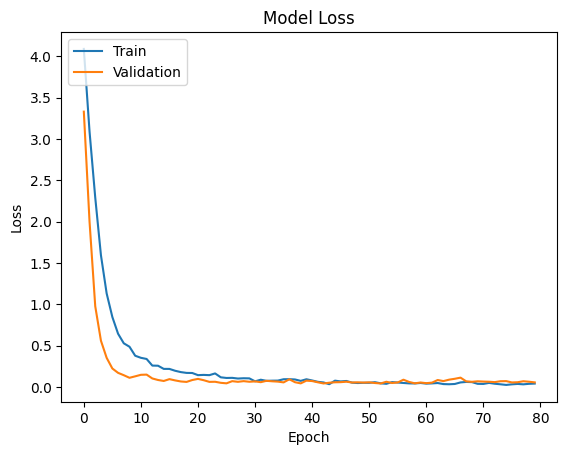

In [100]:
# Plot the training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [101]:
# Load the trained model
model = load_model('guitar_chord_recognition_model.h5')

In [102]:
# Function to predict chords in a new audio file
def predict_chords(file_path, model, encoder, scaler, mfcc_len=100):
    features, _ = extract_features(file_path, mfcc_len=mfcc_len)
    features_flat = features.flatten().reshape(1, -1)
    features_scaled = scaler.transform(features_flat)
    features_scaled = np.expand_dims(features_scaled, axis=-1)
    prediction = model.predict(features_scaled)
    predicted_label_index = np.argmax(prediction)
    predicted_label = encoder.inverse_transform(np.array([predicted_label_index]).reshape(-1, 1))
    return predicted_label[0][0]

In [113]:
import soundfile as sf

def convert_mp3_to_wav(mp3_file, wav_file):
  """Converts an MP3 file to WAV format.

  Args:
    mp3_file: Path to the input MP3 file.
    wav_file: Path to the output WAV file.
  """

  # Read the MP3 file
  data, samplerate = sf.read(mp3_file)

  # Write the data to a WAV file
  sf.write(wav_file, data, samplerate)

# Specify the input and output file paths
mp3_file = 'other.mp3'
wav_file = 'path_to_new_audio_file.wav'

# Convert the MP3 to WAV
convert_mp3_to_wav(mp3_file, wav_file)

In [115]:
# Example usage: predict chords for a new audio file
new_audio_file = 'path_to_new_audio_file.wav'
predicted_chord = predict_chords(new_audio_file, model, encoder, scaler)
print(f'Predicted Chord: {predicted_chord}')

IndexError: list index out of range

In [ ]:
# GENERATING SHEET MUSIC (USING music21)
from music21 import stream, note, chord, duration

def generate_sheet_music(chord_predictions, output_path="sheet_music.xml"):
    music_stream = stream.Stream()
    for chord_name, start_time, end_time in chord_predictions:
        n = note.TextChordSymbol()
        n.addChordStep(chord_name)
        n.quarterLength = (end_time - start_time) * 4  # Adjust based on your tempo
        music_stream.append(n)
    music_stream.write('musicxml', fp=output_path)

In [ ]:
# Example Usage
# Assuming predict_chords returns a list of chords, one for each segment
example_chords = ["C", "G", "Am", "F"]
generate_sheet_music(example_chords)

In [ ]:
# FUNCTION FOR LOADING SAVED MODEL
def load_model():
    return tf.keras.models.load_model("guitar_notes_model.h5")

In [ ]:
# FUNCTION TO PROCESS NEW SONG
def process_new_song(audio_path):
    y, sr = librosa.load(audio_path)
    # Extracting features (e.g., MFCCs, chroma)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean.reshape(1, -1)  # Reshape for prediction

In [ ]:
# FUNCTION TO PREDICT CHORDS
def predict_chords(audio_path):
    model = load_model()
    features = process_new_song(audio_path)
    prediction = model.predict(features)
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label

In [ ]:
# TESTING THE NEW SONG FUNCTION
new_audio_path = "path_to_new_song.wav"
print("Predicted chord for the new song:", predict_chords(new_audio_path))


In [ ]:
# GENERATING SHEET MUSIC (USING music21)
from music21 import stream, note, chord

def generate_sheet_music(chord_predictions, output_path="sheet_music.xml"):
    music_stream = stream.Stream()
    for chord_name in chord_predictions:
        n = note.TextChordSymbol()
        n.addChordStep(chord_name)
        music_stream.append(n)
    music_stream.write('musicxml', fp=output_path)
    print(f"Sheet music exported to {output_path}")

In [ ]:
# Example Usage
# Assuming predict_chords returns a list of chords, one for each segment
example_chords = ["C", "G", "Am", "F"]
generate_sheet_music(example_chords)